# Lab Assignment 3

**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 04.12.20**
* **Bonus problems: deadline for Lab Assignment 4**

**Points: 10 + 7 bonus points**


In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [2]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO
import math
import graphviz
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")



In [3]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Martial Status",
    "Occupation",
    "Relationship",
    "Race",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "target",
]
adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=adult_names,
    header=None,
    na_values="?",
)
adult_test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=adult_names,
    header=None,
    na_values="?",
    skiprows=1,
)

# 5. German Credit

german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    names=[f"A{d}" for d in range(1, 21)] + ["target"],
    header=None,
    sep=" ",
)

# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a columnt of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variables, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the datafranme's `apply` function to compute the entropy of all columns.

In [4]:
def entropy(series):
    res = [len(series[series == x])/series.size * np.log2(len(series[series==x])/series.size)for x in series.drop_duplicates()]
    return round(-np.sum(res),6)

mushroom_df.apply(entropy)


target                      0.999068
cap-shape                   1.652889
cap-surface                 1.575486
cap-color                   2.510143
bruises?                    0.979327
odor                        2.319414
gill-attachment             0.173129
gill-spacing                0.637878
gill-size                   0.892256
gill-color                  3.030433
stalk-shape                 0.986927
stalk-root                  1.822922
stalk-surface-above-ring    1.221348
stalk-surface-below-ring    1.399135
stalk-color-above-ring      1.936809
stalk-color-below-ring      1.978163
veil-type                  -0.000000
veil-color                  0.196238
ring-number                 0.420680
ring-type                   1.535121
spore-print-color           2.203227
population                  2.003398
habitat                     2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighting them by how frequent the $x$ value ocurred.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [5]:
def cond_entropy(df, Y, X):
    """Compute the conditional H(Y|X) in dataframe df
    Args:
        df: a dataframe
        X: the name of the conditioning columt
        Y: the name of the column whose entropy we wish to compute
    """
    grouped = df.groupby(X).count()
    size = grouped[Y].sum()
    uq = df[X].unique()
    res = np.sum([(grouped[Y][x]/size) * entropy(df[Y][df[X] == x]) for x in uq])

    return res

for c in mushroom_df.columns:
    if(c!="target"):
        print(c)
        print(cond_entropy(mushroom_df.copy(), "target",c))
# Now for each column C compute the conditional entropy H(target|C)
# Which variable tells us the most about the target?



cap-shape
0.9502711009354998
cap-surface
0.970477643525357
cap-color
0.9630187804037421
bruises?
0.8066884987690792
odor
0.09299302511078286
gill-attachment
0.9849032459379615
gill-spacing
0.8981848035450517
gill-size
0.7689134726735598
gill-color
0.5820905531757754
stalk-shape
0.9915510974889217
stalk-root
0.8642505475135401
stalk-surface-above-ring
0.7143422609551946
stalk-surface-below-ring
0.7271730989660267
stalk-color-above-ring
0.7452227651403249
stalk-color-below-ring
0.7576525022156574
veil-type
0.999068
veil-color
0.9752508842934515
ring-number
0.960615045790251
ring-type
0.6810463692762185
spore-print-color
0.5183627769571639
population
0.797109929098966
habitat
0.8422342028557361


### Implement infogain ratio [1p]
Add an ID column, that assigns a unique ID to each observation (row). Compute the mutual information between target and ID. How to interpret the results? Do you think the ID is important in predicting the target? Devise a measure similar to Information Gain Ratio from C4.5 and show its variable ranking.



ID is not important in predicting the target, as it dont tells us very little about the target

In [6]:
#I(X ; Y) = H(X) – H(X | Y)
def Mutual_information(df, X, Y):
    HX = entropy(df[X])
    HXY = cond_entropy(df.copy(),X,Y)
    return HX - HXY

def Information_Gain_Ratio(df,X,Y):
    x = entropy(df[Y])
    if(x==0):
        x += 1e-50
    return Mutual_information(df,X,Y) /x

size = mushroom_df["target"].size
ID = np.arange(size)
mushroom_with_id = mushroom_df.copy()
mushroom_with_id["ID"] = ID
for c in mushroom_with_id.columns:
    if(c!="target"):
        print(c)
        print(Information_Gain_Ratio(mushroom_with_id.copy(), "target",c))


print(Mutual_information(mushroom_with_id.copy(),  "target", "ID"))

cap-shape
0.02952218755433676
cap-surface
0.018147007637416595
cap-color
0.014361420682510059
bruises?
0.1964405160185727
odor
0.3906482304966759
gill-attachment
0.08181618366673654
gill-spacing
0.15815437506066718
gill-size
0.25794674098738496
gill-color
0.1375966559314212
stalk-shape
0.007616472658138122
stalk-root
0.07395678613043226
stalk-surface-above-ring
0.23312417021586423
stalk-surface-below-ring
0.19433071221431333
stalk-color-above-ring
0.13106363862398152
stalk-color-below-ring
0.12204024531059503
veil-type
0.0
veil-color
0.12136852040149426
ring-number
0.09140666114326548
ring-type
0.2071638852727449
spore-print-color
0.21818234028669584
population
0.1008077630610762
habitat
0.0689456001675192
ID
0.07692253796300039
0.999068


# Problem 2: Decision Tree Implementation

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine leading toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values if a two-class set with given class probabilities

e    4208
p    3916
Name: target, dtype: int64


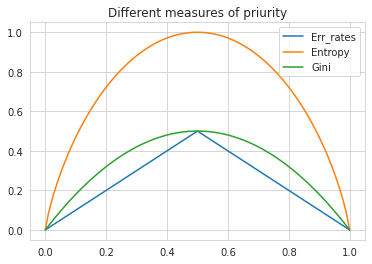

In [7]:
def entropy(counts):
    def logarithm(x):
        if x==0:
            x += 1e-50
        return np.log2(x)
    s = np.sum(counts)
    p = [i/s * logarithm(i/s) for i in counts]
    return -np.sum(np.array(p))



def gini(counts):
    s = counts.sum()
    p = [(i/s)**2 for i in counts]
    return 1 - np.sum(np.array(p))


def mean_err_rate(counts):
    s = counts.sum()
    p = counts / s
    return 1 - p.max()


fractions = np.linspace(0, 1, 101)


# Make a plot of the purity functions
err_rates = [mean_err_rate(np.array([f, 1.0-f])) for f in fractions]

entropies = [entropy(np.array([f, 1.0-f])) for f in fractions]

ginis = [gini(np.array([f, 1.0-f])) for f in fractions]

print(mushroom_df["target"].value_counts())
plt.plot(fractions, err_rates)
plt.plot(fractions, entropies)
plt.plot(fractions, ginis)
plt.title("Different measures of priurity")
plt.legend(('Err_rates', 'Entropy', "Gini"), loc = 'upper right')
plt.show()

## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below, as indicated by the TODO comments.

In [8]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """

    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a subtree for each value that an attribute may take.

In [9]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        val = x[self.attr]
        if val in self.subtrees.keys():
            return self.subtrees[x[self.attr]]
        else: return None

    def iter_subtrees(self):
        return self.subtrees.values()

    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f"{id(parent)}", f"{id(child)}", label=f"{split_name}")

In [10]:
def get_categorical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    mean_child_purity = 0



    all  = df[attr].unique()
    val_counts = df[attr].value_counts()
    sum = np.sum(val_counts)
    for x in all:
        mean_child_purity += purity_fun(df["target"][df[attr]== x].value_counts()) * val_counts[x] / sum
    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - mean_child_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [11]:
def get_split(df, criterion="infogain", nattrs=None):
    """Find best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of smaples in the node to be split
        - criterion: spluis selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """


    # Implement termination criteria:
    # TermCrit1: Node is pure
    target_value_counts = df["target"].value_counts()
    if len(target_value_counts) == 1:
        return None
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.
    possible_splits = []
    for c in df.columns:
        if(c!="target" and len(df[c].unique()) > 1):
            possible_splits.append(c) # possible_splits must be a list
    assert "target" not in possible_splits
    #    Terminate early if none are possivle
    if not possible_splits:
        return None
    

    # Get the base purity measure and the purity function
    if criterion in ["infogain", "infogain_ratio"]:
        purity_fun = entropy
    elif criterion in ["mean_err_rate"]:
        purity_fun = mean_err_rate
    elif criterion in ["gini"]:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # restrict possible_splits to a few radomly selected attributes
    # if nattrs is not None:
    #     possible_splits = TODO
    if nattrs != None:
        if(nattrs < len(possible_splits)):    
            possible_splits = np.random.choice(possible_splits,nattrs, replace = False)
            possible_splits = list(possible_splits)


    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner
            # similar to categorical ones
            split_sel_fun = get_numrical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity

        split, purity_gain = split_sel_fun(
            df,
            base_purity,
            purity_fun,
            attr,
            normalize_by_split_entropy=criterion.endswith("ratio"),
        )

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [12]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values,
        # TODO: remove this for bonus problem #2.4
        assert not df.isnull().values.any()

        # Technicality:
        # We need to let subtrees know about al targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)

        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
            "counts" : self.counts
        }
        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)

    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        else:
            subtri = self.split(sample)
            print(self.split.attr)
            if(subtri != None):
                return subtri.get_target_distribution(sample) 
            else: return self.counts

            # TODO: descend into subtrees and return the leaf target distribution
    def classify(self, sample):
        x = dict(self.get_target_distribution(sample))
        for y in x.keys():
            return y

        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

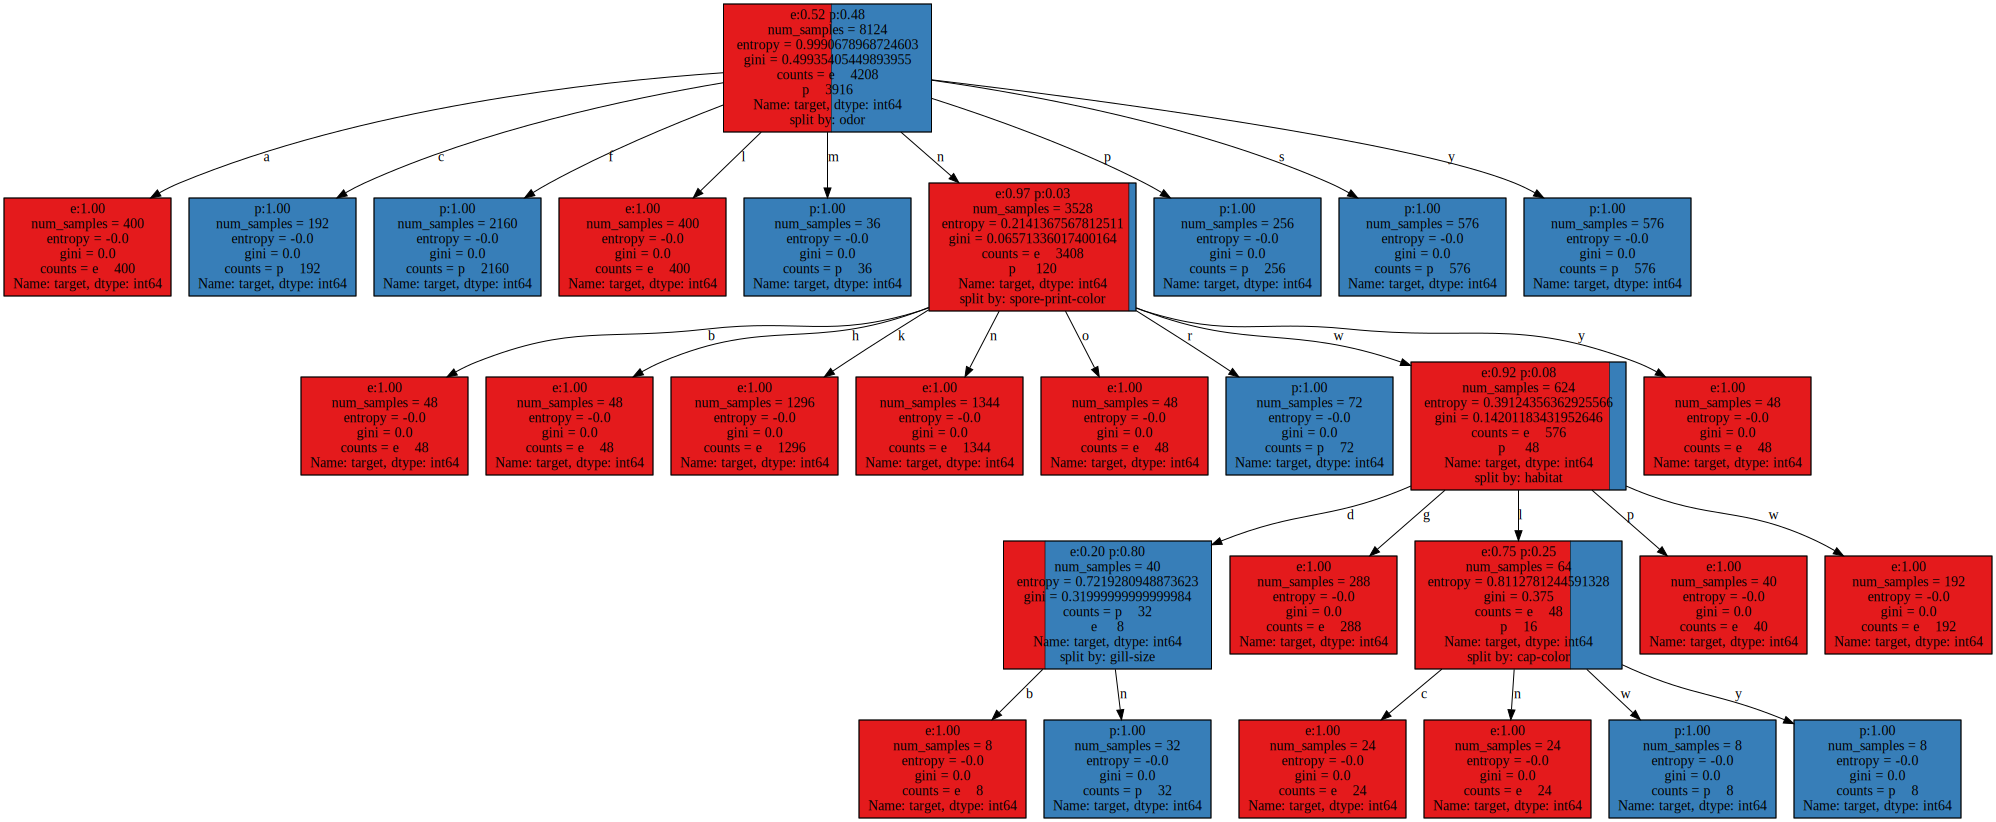

In [13]:
# Train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.

# Note: for this code to work you must fix the todos in the previous sections

mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()


**Answer the questions below**
1. How many samples are classified correctly by a tree with only one split?
2. Is the tree different when different purity functions are used?



1. 4596 with leafes  + 3422.16 (0.97*3528) with one internal node
2. Yes it is, we get different splits for different criterions.



## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [14]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th

    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
            Tree(df[df[self.attr] > self.th], **subtree_kwargs),
        )

    def __call__(self, x):
        val = x[self.attr]
        if val >self.th:
            return self.subtrees[1]
        else:
            return self.subtrees[0]

    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[0])}", label=f"<= {self.th:.2f}")
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[1])}", label=f"> {self.th:.2f}")


def get_numrical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    


    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, "target"]].sort_values(attr)
    _counts = df['target'].value_counts()
    targets = attr_df["target"]
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None  # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    best_threshold = values.iloc[0]
    sum = np.sum(_counts)

    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0
        right_counts[row_target] -=1
        left_counts[row_target] +=1
        # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)
        # the loop should return the best possible split.
        # TODO: update left_counts and right_counts  
        # The split is possible if attribute_value != next_attribute_value
       
        if attribute_value == next_attribute_value:
            continue
       
        mean_child_purity =0

        mean_child_purity += purity_fun(left_counts) * np.sum(left_counts)/sum
        mean_child_purity += purity_fun(right_counts) * np.sum(right_counts)/sum
        purity_gain = parent_purity - mean_child_purity

        if normalize_by_split_entropy:
            purity_gain /= entropy(df['target'].value_counts())

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_threshold = split_threshold
        
    best_split = NumericalSplit(attr, best_threshold)    # TODO: now consider the split at split_threshold and save it if it the best one
    return best_split, best_purity_gain

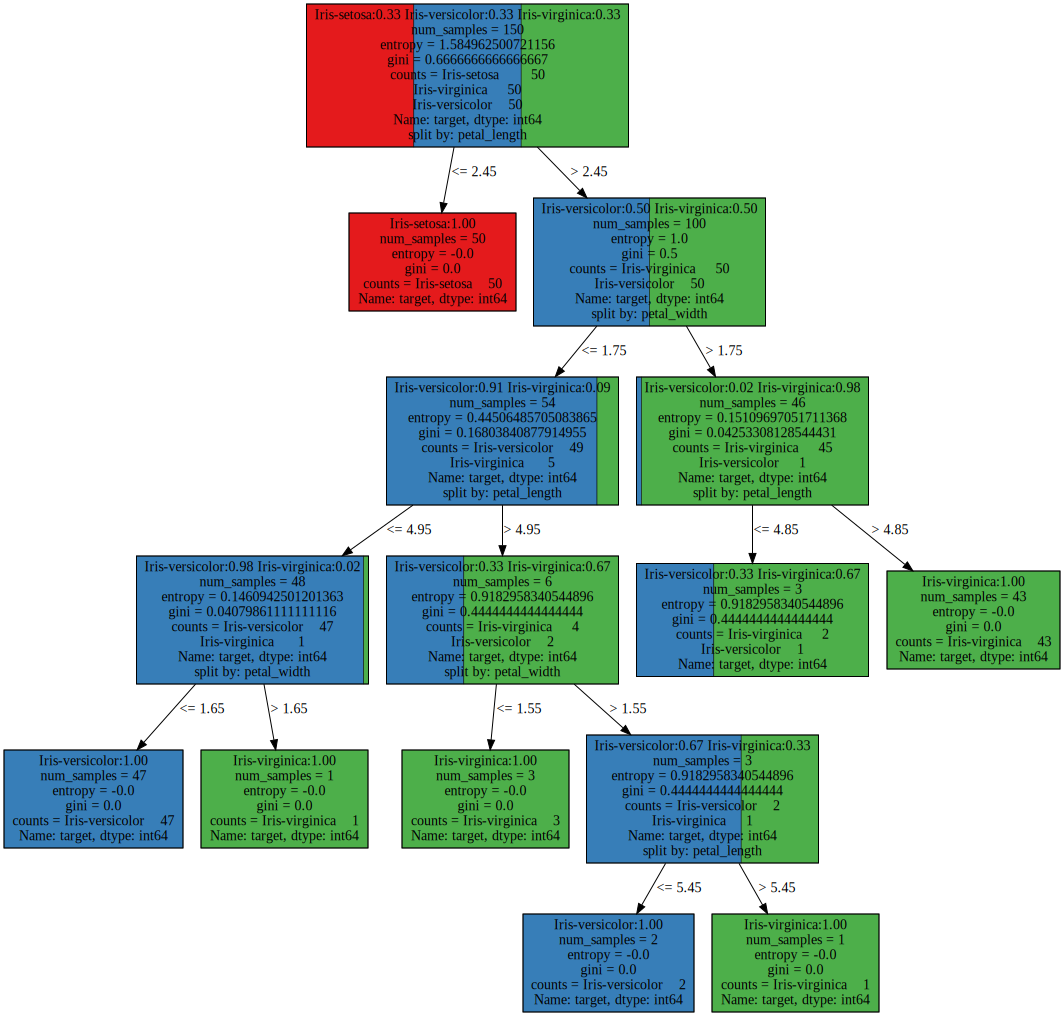

In [15]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[["petal_length", "petal_width", "target"]]
#TODO: build and draw the tree
   
iris_tree = Tree(iris2d)
iris_tree.draw()

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_length
petal_width
petal_length
petal_width
petal_length
petal_length
petal_length
petal_width
petal_length
petal_width
p

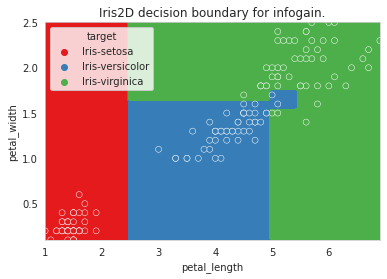

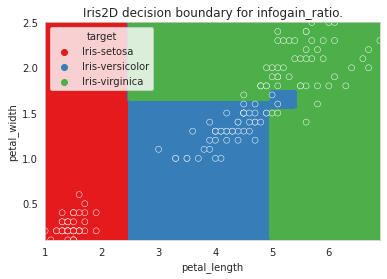

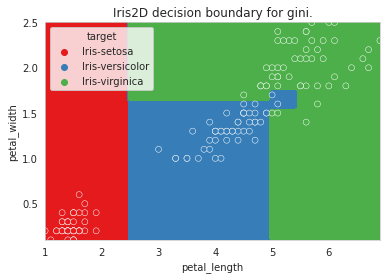

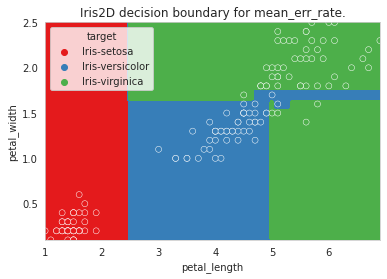

In [16]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty((len(mesh_data),))

for criterion in ["infogain", "infogain_ratio", "gini", "mean_err_rate"]:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(
        mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap="Set1", vmin=0, vmax=7
    )
    sns.scatterplot(
        x="petal_length", y="petal_width", hue="target", data=iris_df, palette="Set1",
    )

## Decision Tree Task 4: Handling missing data [2bp]

Implement support for missing values. A possible strategy does the following:
each time (both during training and testing) we encounter a split for which the smaple misses attribute's value, we a weighted copy of the sample down each subtree, with the weight equal to the probaiblity that the child subtree is selected (i.e. proportional to number of samples put into the subtree.).

In [17]:
class Tree_m:
    def __init__(self, df, **kwargs):
        super().__init__()


        ## REPLACING MISSING VALUES WITH np.NaN
        df = df.replace('na', np.NaN)
        df = df.replace('nan', np.NaN)
        df = df.replace('', np.NaN)
        self.df = df
        for x in range(len(df)):
            self.df.iloc[x] = self.find_and_replace(self.df.iloc[x])

        # Technicality:
        # We need to let subtrees know about al targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)

        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
            "counts" : self.counts
        }
        self.df = df
        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)


    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        else:
            subtri = self.split(sample)
            print(self.split.attr)
            if(subtri != None):
                return subtri.get_target_distribution(sample) 
            else: return self.counts

## HANDLING MISSING VALUES
    def get_value(self,sample, column):
        dict_ = {}
        for col in self.df.columns:
            if str(col) != str(column):
                indexs = (self.df[col]==sample[col]).to_numpy()
                dict_[col] = self.df.iloc[indexs][column].value_counts()
                if not(dict_[col].empty):
                    id_max = dict_[col].idxmax()
                    dict_[col] = (dict_[col][id_max] / np.sum(dict_[col]), id_max) 
                else: dict_[col] = (0, 'nan')

        for k, v in sorted(dict_.items(), key=lambda item: item[1][0], reverse = True):
            return v[1]

    def find_and_replace(self, sample):
        columns = self.df.columns
        for c in columns:
            if str(sample[c]) == 'nan':
                sample[c] = self.get_value(sample.copy(),c)
        return sample

            # TODO: descend into subtrees and return the leaf target distribution
    def classify(self, sample, missing = True):
        if missing:
            sample = self.find_and_replace(sample)
            return self.classify(sample, missing = False)
        else:
            x = dict(self.get_target_distribution(sample))
            for y in x.keys():
                return y

    def classify_(self, sample):
        x = dict(self.get_target_distribution(sample))
        for y in x.keys():
            return y
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

In [18]:
import seaborn as sns

vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(
    vote_df, test_size=0.3)

vote_tree_missing = Tree(vote_train_df)
vote_tree_fixed = Tree_m(vote_train_df)

targets = vote_test_df['target']
preds_missing = []
preds_fixed = []
for i,row in vote_test_df.iterrows():
    preds_missing.append(vote_tree_missing.classify(row))
    preds_fixed.append(vote_tree_fixed.classify(row))

print("Accuracy for decision tree that doesnt deal with missing values {}".format(np.sum(preds_missing == targets) / len(targets)))
print("Accuracy for decision tree that deals with missing values {}".format(np.sum(preds_fixed == targets) / len(targets)))

physician-fee-freeze
physician-fee-freeze
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
immigration
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
immigration
physician-fee-freeze
adoption-of-the-budget-resolution
physician-fee-freeze
adoption-of-the-budget-resolution
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
physician-fee-freeze
adoption-of-the-budget-resolution
physician-fee-freeze
adoption-of-the-budget-resolution
physician-fee-freeze
adoption-of-the-budget-resolution
physician-fee-freeze
adoption-of-the-budget-resolution
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
physician-fee-freeze
synfuels-corporation-cutback
duty-free-exports
physician-fee-freeze
adoption-of-the-budget-resolution
physi

Text(0.5, 1.0, 'Does not contain missing values')

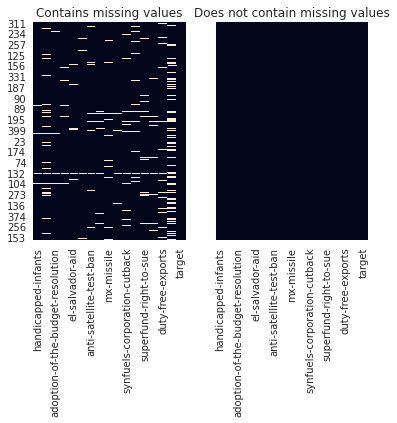

In [19]:
vote_train_df = vote_train_df.replace('na', np.NaN)
vote_train_df = vote_train_df.replace('nan', np.NaN)
vote_train_df = vote_train_df.replace('', np.NaN)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
g1 = sns.heatmap(vote_train_df.isna(),cbar=False,ax=ax1)
g1.set_title("Contains missing values")

g2 = sns.heatmap(vote_tree_fixed.df.isna(),cbar=False,ax=ax2)
g2.set_title("Does not contain missing values")



## Decision Tree Task 5: Pruning [2-4bp]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning
Build a tree using all the data. Then split the training set into 10 crossvalidation subsets. Then in a loop over the tesintg crossvalidation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning
Build the deicision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.

As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

In [20]:

class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values,
        # TODO: remove this for bonus problem #2.4
        assert not df.isnull().values.any()

        # Technicality:
        # We need to let subtrees know about al targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)

        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
            "counts" : self.counts,
            "error" : 0,
            "classify_count" : 0,
            "error_rate" : 0
        }

        # updating info with 0 counts for every target
        for x in self.all_targets:
            self.info[str(x)] = 0
        
    
        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)

    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        else:
            subtri = self.split(sample)
            if(subtri != None):
                return subtri.get_target_distribution(sample) 
            else: return self.counts
          
    def classify(self, sample):
        x = dict(self.get_target_distribution(sample))
        for y in x.keys():
            return y


    ## ERROR RATE PRUNNING

    def get_target_distribution_prunning(self,sample):
            self.info[str(sample['target'])] +=1
            if self.split is None:
                return self.counts
            else:
                subtri = self.split(sample)
                if(subtri != None):
                    return subtri.get_target_distribution_prunning(sample) 
                else: return self.counts

    def classify_prunning(self, sample):
        target = sample['target']
        classi = self.info['counts'].idxmax()

        if target != classi:
            self.info['error'] +=1
    
        self.info['classify_count'] +=1      

        if self.split is None:
            return self.counts
        else:
            subtri = self.split(sample)
            if(subtri != None):
                return subtri.classify_prunning(sample)
            else: return self.counts

    def get_error_rate(self):
        self.info['error_rate'] = self.info['error'] / max(self.info['classify_count'],1)
        if self.split != None:
            for tree in self.split.iter_subtrees():
                if tree != None:
                    tree.get_error_rate()

    def check_if_leaf_node(self):
        for x in self.split.iter_subtrees():
            if x.split == None:
                return True
        return False

    def delete_leaf_nodes_prunning(self):
        self.get_error_rate()
        keys = []
        if self.split != None:
            for key, value in self.split.subtrees.items():
                if value.info['error_rate'] > self.info['error_rate']:
                    keys.append(key)
            for key in keys:
                if self.split.subtrees[key].check_if_leaf_node():           
                    del self.split.subtrees[key]
            for tree in self.split.iter_subtrees():
                tree.delete_leaf_nodes_prunning()

    def clear_info(self):
        for x in self.all_targets:
            self.info[str(x)] = 0
        self.info['classify_count'] = 0
        self.info['error'] = 0
        if self.split != None:
            for w in self.split.iter_subtrees():
                w.clear_info()



    ## CONFIDENCE INTERVAL PRUNNING

    def get_confidence_interval(self, z = 1.96):
        # z = 1.96 so we get 95% confidence interval
        error = np.sum(self.counts)
        error -= self.counts[self.counts.idxmax()]
        
        confidence_interval = z * np.sqrt((error/np.sum(self.counts) * (1 - error/np.sum(self.counts))) / np.sum(self.counts))
        self.info['confidence_interval'] = confidence_interval
        self.info['upper_bound_interval'] = confidence_interval + z


    def push_confidence_interval(self):
        self.get_confidence_interval()
        if self.split != None:
            for tree in self.split.iter_subtrees():
                tree.push_confidence_interval()

    def prune_with_confidence_interval(self):
        self.push_confidence_interval()
        keys = []
        if self.split != None:
            for key, value in self.split.subtrees.items():
                if value.info['upper_bound_interval'] > self.info['upper_bound_interval']:
                    keys.append(key)
           
            for key in keys:    
                del self.split.subtrees[key]

            for tree in self.split.iter_subtrees():
                tree.prune_with_confidence_interval()

### VISUALIZATION

    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot



    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

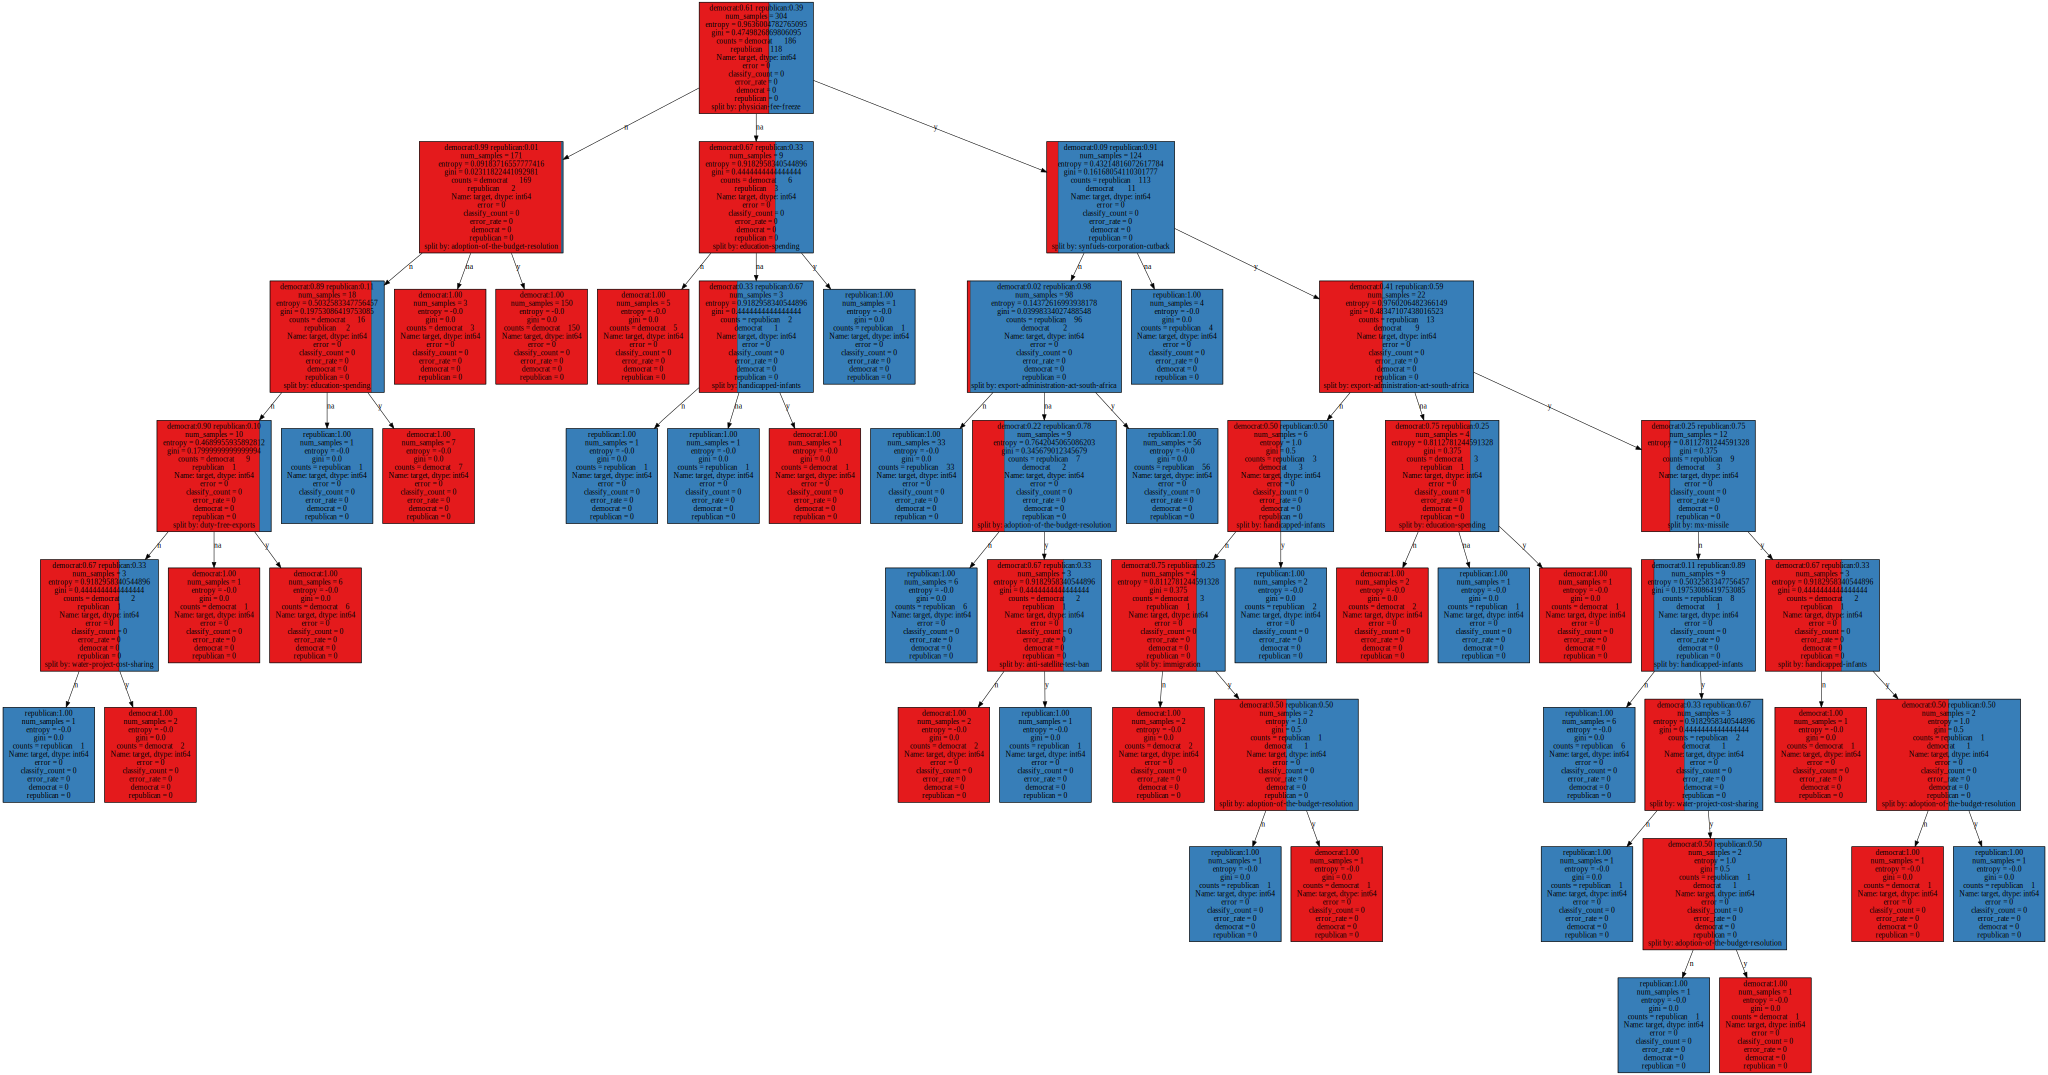

In [21]:
vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(
    vote_df, test_size=0.3)


prunned_vote_tree = Tree(vote_train_df)
normal_vote_tree = Tree(vote_train_df)
confidence_prunned_vote_tree = Tree(vote_train_df)
confidence_prunned_vote_tree.prune_with_confidence_interval()
normal_vote_tree.draw()

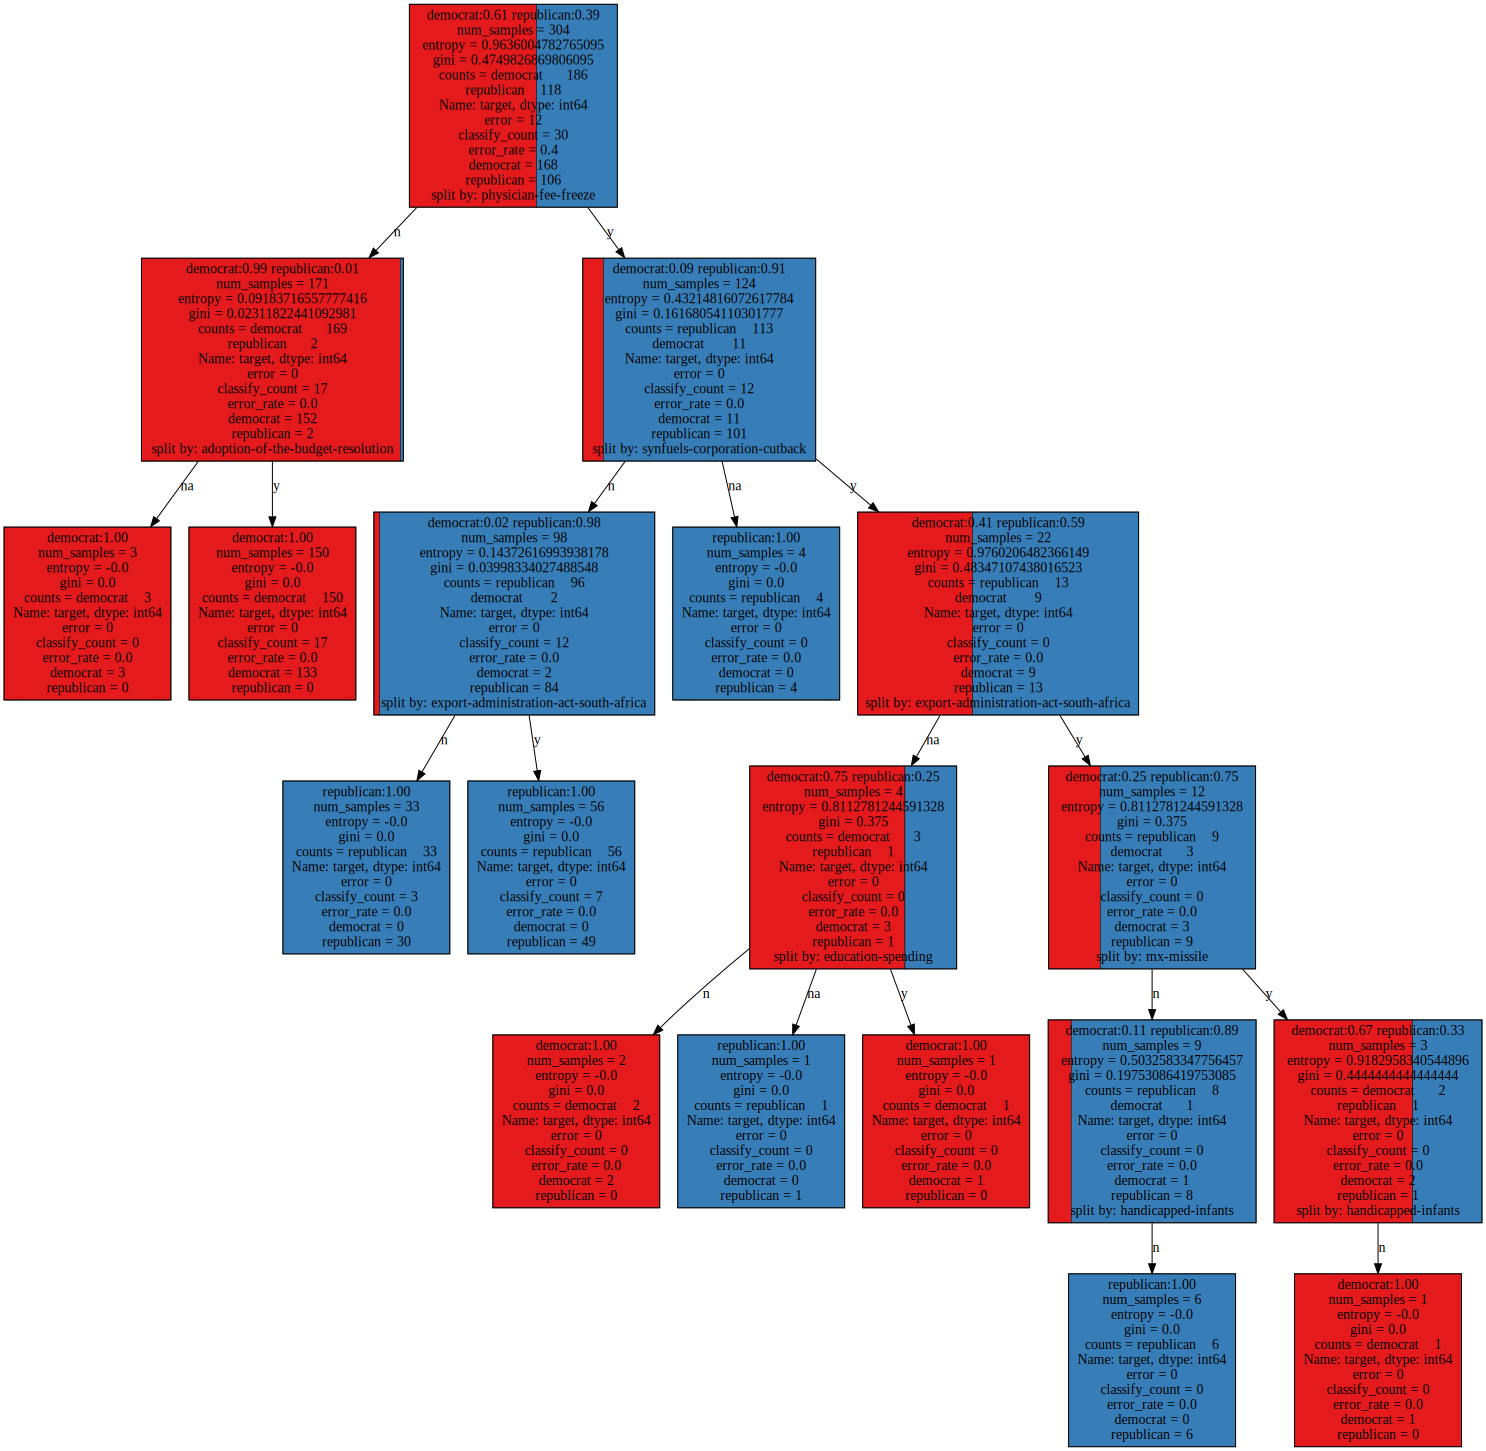

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10)
kf.get_n_splits(vote_train_df)

## ERROR RATE PRUNNING
for train_index, test_index in kf.split(vote_train_df):
    X_train = vote_train_df.iloc[train_index]
    X_test = vote_train_df.iloc[test_index]
    prunned_vote_tree.clear_info()
    for i,row in X_train.iterrows():
        prunned_vote_tree.get_target_distribution_prunning(row)
    for i, row in X_test.iterrows():
        prunned_vote_tree.classify_prunning(row)
    prunned_vote_tree.delete_leaf_nodes_prunning()    


prunned_vote_tree.draw()

In [23]:
prunned_preds = []
normal_preds = []
prunned_confidence = []

y_test = vote_test_df['target']
for i,row in vote_test_df.iterrows():
    prunned_preds.append(prunned_vote_tree.classify(row))
    normal_preds.append(normal_vote_tree.classify(row))
    prunned_confidence.append(confidence_prunned_vote_tree.classify(row))

print("Accuracy for error rate prunned tree : {}".format((np.sum(prunned_preds == y_test)/ len(y_test))))
print("Accuracy for normal tree : {} ".format((np.sum(normal_preds == y_test)/ len(y_test))))
print("Accuracy for confidence interval prunned tree : {} ".format((np.sum(prunned_confidence == y_test)/ len(y_test))))

Accuracy for error rate prunned tree : 0.9694656488549618
Accuracy for normal tree : 0.9541984732824428 
Accuracy for confidence interval prunned tree : 0.9770992366412213 


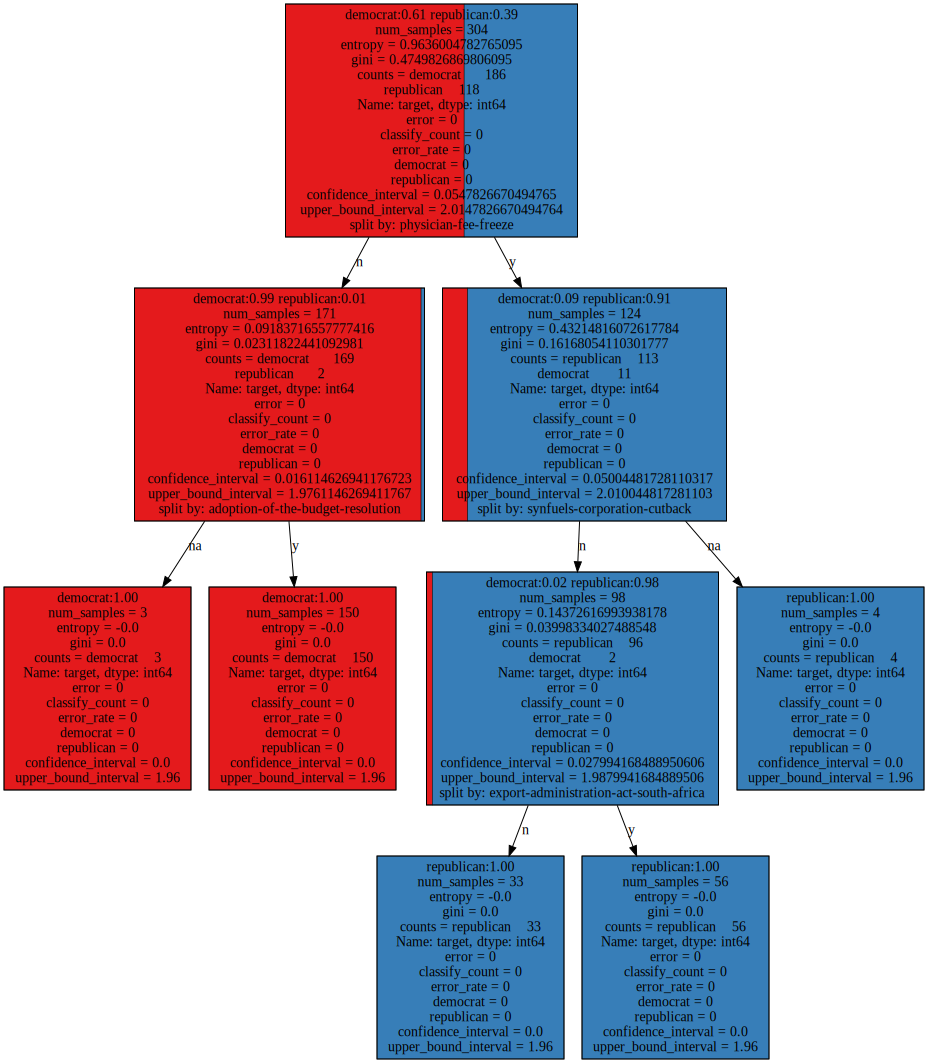

In [24]:
confidence_prunned_vote_tree.draw()


# Problem 4: Random Forest [3p]

We will use the german credit dataset. Please split it into a training and testing set using a 70%-30% ratio.

Next train and test a regular decision tree on it.

Then:
1. Implement randomized tree bulding, by restricting the set of attrbutes considered for data spltting in the tree building code below (the `nattrs` argument). Alternatively, you can use trees from sklearn (se below).
2. Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute the tree's test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

**Note:** This assignment assumes that you use either your own implementation of the decision tree from Problem 3, or the implementation of [trees from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since sklearn's trees don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. last year's AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode the categorical variables using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set? 

Answer :
We do bootstraping because even small change in our sample space can give various results so we ensure the trees become uncorrelated. The same goes for number of attributes. If we set number of attributes to a high number we may get multiple similar trees so the results may be similar to the one we get from one 'normally' trained tree because the trees wont be uncorrelated.  As number of attributes increases, we get higher agreements between forrest.

In [25]:
german_train_df, german_test_df = sklearn.model_selection.train_test_split(
    german_df, test_size=0.3)
german_tree = Tree(german_train_df, criterion = 'mean_err_rate')
preds = []
for x,row in german_test_df.iterrows():
    preds.append(german_tree.classify(row))

targets = german_test_df['target']

def error(df, preds):
    all = len(df)
    return 1 - (len(df['target'][df['target'] == preds]) / all)

print("Accuracy for a single tree {}".format(1 - error(german_test_df, preds)))




Accuracy for a single tree 0.61


In [26]:

    
class RandomForestTrees:
    def __init__(self, df, nattrs, n, criterion):
        self.df = df
        self.criterion = criterion
        self.nattrs = nattrs
        self.n = n
        self.forest = {}

    def bootstrap(self):
        return self.df.sample(len(self.df), replace=True)

    def add_tree(self, tree, df):
        self.n +=1 
        self.forest [n] = (tree,df)


    def predict_xi(self,tree,xi):
        return tree.classify(xi)
    
    def get_accuracy_tree(self,df,n):
        return 1 - self.error_rate_tree(df, n)
    
    def get_mean_accuracy(self,df):
        acc = []
        for x in range(self.n):
            acc.append(self.get_accuracy_tree(df,x))
        acc = np.array(acc)
        return np.mean(acc)

    def create_trees(self):
        for x in range(self.n):
            bootstraped_df = self.bootstrap()
            self.forest[x] = (Tree(bootstraped_df, nattrs = self.nattrs, criterion = self.criterion), bootstraped_df, self.df[~self.df.isin(bootstraped_df.drop_duplicates())].dropna())
    
    def predict_tree(self,df,n):
        all = len(df)
        targets = df['target']
        preds = []
        tree = self.forest[n][0]
        for row in df.iterrows():
            pred = tree.classify(row[1])
            preds.append(pred)
        preds = np.array(preds)
        return preds

    def error_rate_tree(self, df,n):
        all = len(df)
        targets = df['target']
        preds = self.predict_tree(df,n)
        return self.error(df, preds)

    def error(self, df, preds):
        all = len(df)
        return 1 - (len(df['target'][df['target'] == preds]) / all)

    def obb_error_tree(self,n):
        targets = ['target']
        bootstraped_df = self.forest[n][1].drop_duplicates()
        obb_df = self.df[~self.df.isin(bootstraped_df)].dropna()
        all = len(obb_df)
        preds = self.predict_tree(obb_df,n)
        return self.error(obb_df,preds)

    def print_forest(self,df):
        print("For {} number of attrs".format(self.nattrs))
        x = self.n
        self.n = 1
        for i in range(x):
            err = self.error_rate_tree(df,i)
            oob = self.obb_error_tree(i)
            forest_acc =  1 - self.forest_accuracy(df)
            print("{} Tree , OOB error of this tree  : {}, ERROR Rate of this tree : {}. Forrest with this many trees has : {} accuracy".format(i, oob, err, forest_acc))
            print(" ")
            self.n += 1
        self.n = x
        print("Forrest Agreements {}, Forrest OBB Error  {} ".format(self.get_agreement_forest(df), self.get_forest_OBB()))
        print("Mean trees accuracy {}".format(self.get_mean_accuracy(df)))
        

    def get_forest_preds(self,df):
        all_preds = []
        forest_preds = []
        for x in range(self.n):
            all_preds.append(list(self.predict_tree(df,x)))

        for i in range(len(df)):
            preds_i_target = []
            for x in all_preds:
                preds_i_target.append(x[i])
            forest_preds.append(np.bincount(np.array(preds_i_target)).argmax())
        return forest_preds

    def get_agreement_between(self, df, x, y):
        tree_1_preds = np.array(self.predict_tree(df,x))
        tree_2_preds = np.array(self.predict_tree(df,y))
        return np.sum(tree_1_preds == tree_2_preds) / len(tree_1_preds)

    def get_agreement_forest(self,df):
        agreements = []
        for x in range(self.n):
            for i in range(x+1, self.n):
                agreements.append(self.get_agreement_between(df, x, i))
        return np.mean(np.array(agreements))

    def get_most_common(self, preds):
        return np.bincount(np.array(preds)).argmax()

    def forest_accuracy(self, df):
        preds = self.get_forest_preds(df)
        return self.error(df,preds)

    def get_forest_OBB(self):
        forest_preds = []
        for x,row in self.df.iterrows():
            oob_preds = []
            for i in range(self.n):
                if x in self.forest[i][2].index:
                    oob_preds.append(self.predict_xi(self.forest[i][0], row))
            if(len(oob_preds)>0):
                forest_preds.append(self.get_most_common(oob_preds))
            else: forest_preds.append(0)
        return self.error(self.df, forest_preds)


RF = RandomForestTrees(german_train_df, 1, 20, criterion = 'infogain')        




RF.create_trees()
#print(RF.error_rate_tree(german_test_df,0))
#print(RF.obb_error_tree(0))
#print(RF.forrest_accuracy(german_test_df))
print(RF.get_forest_OBB())
RF.print_forest(german_test_df)

0.2671428571428571
For 1 number of attrs
0 Tree , OOB error of this tree  : 0.38842975206611574, ERROR Rate of this tree : 0.3866666666666667. Forrest with this many trees has : 0.6133333333333333 accuracy
 
1 Tree , OOB error of this tree  : 0.3827160493827161, ERROR Rate of this tree : 0.32999999999999996. Forrest with this many trees has : 0.6933333333333334 accuracy
 
2 Tree , OOB error of this tree  : 0.38095238095238093, ERROR Rate of this tree : 0.3733333333333333. Forrest with this many trees has : 0.6866666666666666 accuracy
 
3 Tree , OOB error of this tree  : 0.3268482490272373, ERROR Rate of this tree : 0.4. Forrest with this many trees has : 0.7066666666666667 accuracy
 
4 Tree , OOB error of this tree  : 0.36900369003690037, ERROR Rate of this tree : 0.3633333333333333. Forrest with this many trees has : 0.7 accuracy
 
5 Tree , OOB error of this tree  : 0.3529411764705882, ERROR Rate of this tree : 0.33999999999999997. Forrest with this many trees has : 0.71 accuracy
 
6 

In [27]:
RF_2 = RandomForestTrees(german_train_df, 2, 20, criterion = 'mean_err_rate')    
RF_2.create_trees() 
RF_2.print_forest(german_test_df)

For 2 number of attrs
0 Tree , OOB error of this tree  : 0.368, ERROR Rate of this tree : 0.3866666666666667. Forrest with this many trees has : 0.6133333333333333 accuracy
 
1 Tree , OOB error of this tree  : 0.34765625, ERROR Rate of this tree : 0.3866666666666667. Forrest with this many trees has : 0.6833333333333333 accuracy
 
2 Tree , OOB error of this tree  : 0.3426294820717132, ERROR Rate of this tree : 0.32999999999999996. Forrest with this many trees has : 0.6766666666666666 accuracy
 
3 Tree , OOB error of this tree  : 0.3214285714285714, ERROR Rate of this tree : 0.38. Forrest with this many trees has : 0.6933333333333334 accuracy
 
4 Tree , OOB error of this tree  : 0.35361216730038025, ERROR Rate of this tree : 0.3633333333333333. Forrest with this many trees has : 0.6833333333333333 accuracy
 
5 Tree , OOB error of this tree  : 0.4015151515151515, ERROR Rate of this tree : 0.3633333333333333. Forrest with this many trees has : 0.7066666666666667 accuracy
 
6 Tree , OOB er

In [28]:
RF_3 = RandomForestTrees(german_train_df, 3, 20,criterion = 'infogain')     
RF_3.create_trees()
RF_3.print_forest(german_test_df)

For 3 number of attrs
0 Tree , OOB error of this tree  : 0.33976833976833976, ERROR Rate of this tree : 0.37. Forrest with this many trees has : 0.63 accuracy
 
1 Tree , OOB error of this tree  : 0.3359073359073359, ERROR Rate of this tree : 0.31333333333333335. Forrest with this many trees has : 0.71 accuracy
 
2 Tree , OOB error of this tree  : 0.30827067669172936, ERROR Rate of this tree : 0.36. Forrest with this many trees has : 0.6866666666666666 accuracy
 
3 Tree , OOB error of this tree  : 0.32558139534883723, ERROR Rate of this tree : 0.35. Forrest with this many trees has : 0.7233333333333334 accuracy
 
4 Tree , OOB error of this tree  : 0.3654618473895582, ERROR Rate of this tree : 0.41000000000000003. Forrest with this many trees has : 0.7 accuracy
 
5 Tree , OOB error of this tree  : 0.3294573643410853, ERROR Rate of this tree : 0.3666666666666667. Forrest with this many trees has : 0.7066666666666667 accuracy
 
6 Tree , OOB error of this tree  : 0.3236363636363636, ERROR R

In [29]:
RF_10 = RandomForestTrees(german_train_df, 10, 20, criterion = 'gini')
RF_10.create_trees()
RF_10.print_forest(german_test_df)  


For 10 number of attrs
0 Tree , OOB error of this tree  : 0.32567049808429116, ERROR Rate of this tree : 0.3666666666666667. Forrest with this many trees has : 0.6333333333333333 accuracy
 
1 Tree , OOB error of this tree  : 0.27586206896551724, ERROR Rate of this tree : 0.33333333333333337. Forrest with this many trees has : 0.6666666666666666 accuracy
 
2 Tree , OOB error of this tree  : 0.32307692307692304, ERROR Rate of this tree : 0.3566666666666667. Forrest with this many trees has : 0.6666666666666666 accuracy
 
3 Tree , OOB error of this tree  : 0.3524904214559387, ERROR Rate of this tree : 0.3433333333333334. Forrest with this many trees has : 0.6966666666666667 accuracy
 
4 Tree , OOB error of this tree  : 0.34782608695652173, ERROR Rate of this tree : 0.3566666666666667. Forrest with this many trees has : 0.6866666666666666 accuracy
 
5 Tree , OOB error of this tree  : 0.36802973977695164, ERROR Rate of this tree : 0.38. Forrest with this many trees has : 0.6966666666666667 